In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from utils import Ngram

## Vector Space

 1. take unigram term-document vectors from n-gram matrix
 2. apply PCA (or UMAP directly?) for dimensionality reduction (original vectors have dimensionality > 10k)
 3. write vectors to .tsv -- also write vector features to file (term, avg pmi?, ...) -> for visualisation in embedding projector
 4. use KDTree (or KMeans?; -> elbow curve) for clusters

In [2]:
NG = Ngram.load("counts", precompute_freqs=True)

tfidf = TfidfTransformer()
ti_mat = tfidf.fit_transform(NG.term_doc_matrix)

None-grams: Term frequencies precomputed...
None-grams: Init done


In [6]:
uni_voc = NG.vocab(1, with_inds=True)

r = len(uni_voc)//2

sub_voc = sorted(np.random.choice(list(uni_voc.keys()), r))
sub_inds = [uni_voc[w] for w in sub_voc]

sub_mat = ti_mat[:, sub_inds].T.toarray()

In [7]:
len(NG.vocab(1)), sub_mat.shape

(27104, (13552, 11199))

(0.0, 0.1)

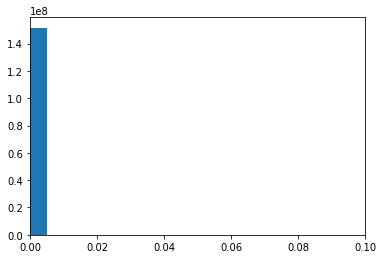

In [9]:
plt.hist(sub_mat.sum(), bins=200)
plt.xlim((0.0, 0.1))

(0.0, 40)

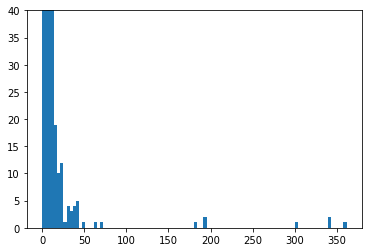

In [16]:
plt.hist(sub_mat.sum(1), bins=100)
plt.ylim((0., 40))

In [ ]:
sum(NG.term_doc_matrix < 1)

/home/valentin/.local/lib/python3.6/site-packages/scipy/sparse/compressed.py:290: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=512)
Y = pca.fit_transform(sub_mat)

In [ ]:
from umap import UMAP


umap = UMAP(n_neighbors=15, n_components=512, verbose=100)

In [ ]:
Y = umap.fit_transform(sub_mat)
Y.shape

In [ ]:
sns.histplot(Y.mean(1))

### Write to TSV

In [ ]:
vec_df = pd.DataFrame(Y)

vec_df.to_csv(f"vecs_umap_{len(sub_inds)}.tsv", sep="\t", index=False, header=False)

In [ ]:
v_to_tsv = lambda v: "\t".join(map(str, v))

# fewer_vecs = np.random.permutation(list(vecs.items()))[:5000]

with open(f"vecs_pca_{len(sub_inds)}.tsv", "w") as handle:
    for v in tqdm(Y):
        handle.write(v_to_tsv(v))
        handle.write("\n")

In [ ]:
# def get_pmi(w):
#     for w2 in NG.vocab(1):
#         try:
#             yield NG.pmi(w, w2)
#         except ValueError:
#             continue

# avg_pmis = [np.mean(list(get_pmi(w))) for w in tqdm(sub_voc)]


term_freqs = [np.log(NG.freq(w)) for w in sub_voc]

meta_df = pd.DataFrame(dict(term=sub_voc,
                           freq=term_freqs))

meta_df.to_csv(f"meta_umap_{len(sub_inds)}.tsv", sep="\t", index=False, header=True)

# with open(f"meta_umap_{len(sub_inds)}.tsv", "w") as handle:
#     for w in sub_voc:
#         handle.write(str(w)+"\n")

# Semantic Similarity vs PMI 

In [ ]:
from numpy.linalg import norm

cos_sim = lambda a, b: np.dot(a, b)/(norm(a)*norm(b))
sub_d = dict(zip(sub_voc, range(len(sub_voc))))

def get_similarity_pmi_pairs():
    for w in tqdm(NG.vocab(2)):
        w1, w2 = w.split()
        if w1 in sub_d and w2 in sub_d:
            cur_pmi = NG.pmi(w1, w2)
            cur_sim = cos_sim(Y[sub_d[w1]], Y[sub_d[w2]])
            yield cur_pmi, cur_sim
            
pmis, sims = list(zip(*get_similarity_pmi_pairs()))
            

In [ ]:
pmis[:10], sims[:10]

In [ ]:
sns.jointplot(x=pmis, y=sims)

## Clusters

In [ ]:
from sklearn.neighbors import KDTree

tree = KDTree(vectors.toarray(), metric="l2")